##Situaton:
You work as a data scientist at a credit card company. 
A senior VP is leading an effort to reduce costs associated with signup 
incentives by offering credit cards with carefully targeted benefits 
that will attract new cardholders. As a first step, she would like you 
to examine cardholder data collected over the last 6 months in order to 
understand the various kinds of users who use the company’s products. 
She is especially interested in getting an idea of which benefits to 
associate with each new card offering.

##Goal:
Attract new customers
& 
Reduce costs associated with signup incentives

##Approach:
Offer targeted benefits that attract new customers


In [0]:
# Tools 
import os 
import pandas as pd
import pandas_profiling
import seaborn as sns 
import numpy as np 
import math
import matplotlib.pyplot as plt
%pylab inline
from sklearn import preprocessing as pp
from sklearn.cluster import KMeans

# Libraries for statistics
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import skew

Populating the interactive namespace from numpy and matplotlib


In [0]:
# read the data 
df= pd.read_csv('cc_info.csv')

# to run it directly in your chrome browser 
# setting local directory 
path = "$YOUR_PATH_TO_DATA/"
os.chdir(path)

## 1. Exploratory Data Analysis

1.1 distribution of the data 

1.2 feature correlation 

1.3 Transforming the data due to their non-normality, here I used the Yeo-Johanson transform, for stabilizing variance and minimizing skewness (estimated through maximum likelihood), I will define skewness_threshold as 1. If any feature has higher score of skewness than the skewness_threshold, I will transform its distribution, then I checked their distribution plots again 
 (Note: Box-cox could also be a good option, but it requires data to be positive.),


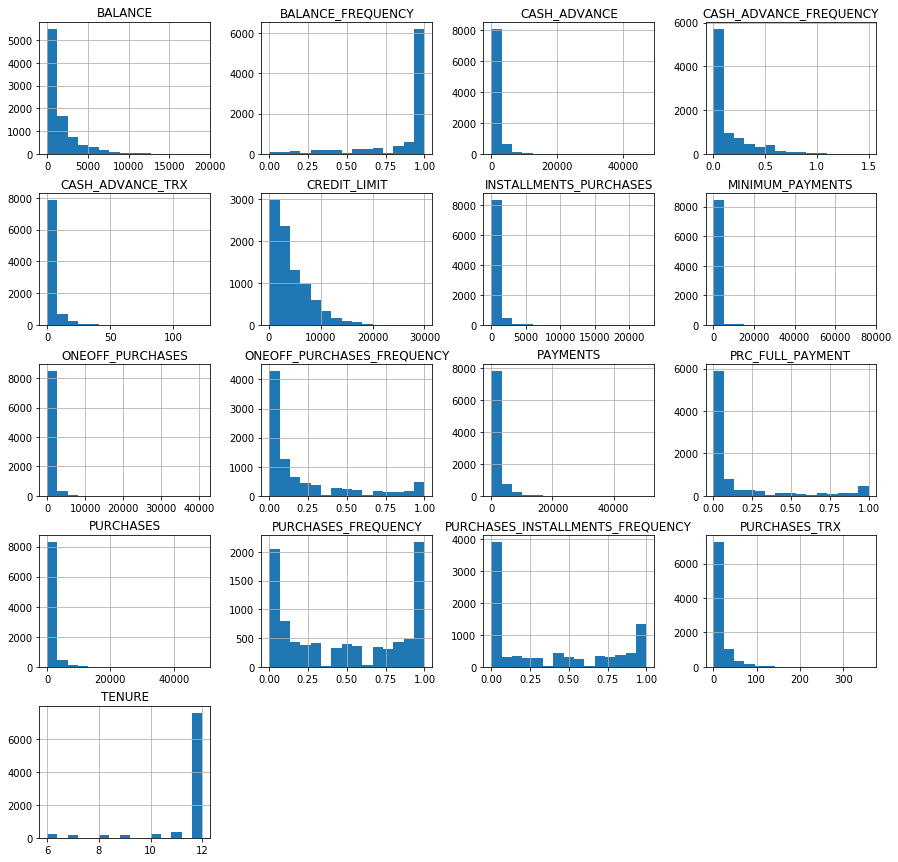

In [0]:
#1.1 histogram plots 
df.hist(figsize=(15,15),bins=15)
plt.show()


PURCHASES                         BALANCE                             0.006473
                                  MINIMUM_PAYMENTS                    0.007771
TENURE                            PRC_FULL_PAYMENT                    0.020244
CREDIT_LIMIT                      PRC_FULL_PAYMENT                    0.020873
PURCHASES_TRX                     MINIMUM_PAYMENTS                    0.025017
                                  BALANCE                             0.046455
PURCHASES_INSTALLMENTS_FREQUENCY  CREDIT_LIMIT                        0.047366
PRC_FULL_PAYMENT                  ONEOFF_PURCHASES                    0.048545
MINIMUM_PAYMENTS                  ONEOFF_PURCHASES_FREQUENCY          0.051143
                                  INSTALLMENTS_PURCHASES              0.051883
ONEOFF_PURCHASES_FREQUENCY        PRC_FULL_PAYMENT                    0.061001
BALANCE                           TENURE                              0.065845
MINIMUM_PAYMENTS                  ONEOFF_PURCHASES  

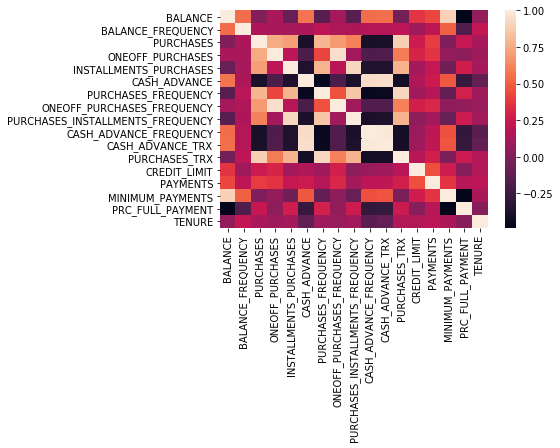

In [0]:
#1.2 feature correlation 
col_names = df.drop('CUST_ID', 
                          axis=1).select_dtypes(exclude = ['object']).columns.values
corr = df[col_names].corr(method='spearman')
sns.heatmap(corr, xticklabels=corr.columns.values,yticklabels=corr.columns.values)
corr_dedup=corr.abs().unstack().sort_values().drop_duplicates() 
print(corr_dedup)
# next, I decided to remove the one of correlated features if their r > 0.9, 
remove_features= ['CASH_ADVANCE_FREQUENCY','CASH_ADVANCE_TRX','ONEOFF_PURCHASES_FREQUENCY',
                  'PURCHASES_INSTALLMENTS_FREQUENCY','PURCHASES_TRX']
# remove the one of the correlated features
df2 = df[list(set(col_names)-set(remove_features))]
col_features = df2.columns.values

    # I will continue analysis with the col_features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a264b4828>,
      dtype=object)

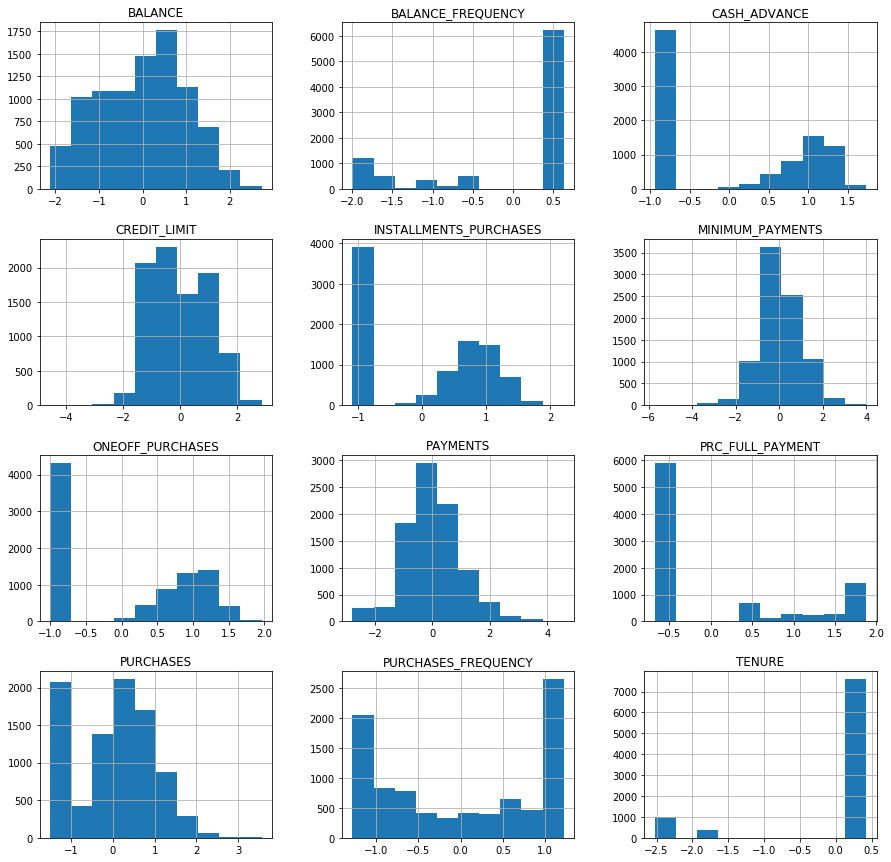

In [0]:
#1.3 Transforming the data due to their non-normality
from sklearn.preprocessing import power_transform
#Check skewness
skew_threshold = 1
num_skewness = df2[col_features].apply(lambda x: skew(x.dropna()))

highly_skewed_col_names = col_features[abs(num_skewness) >= skew_threshold]
lowly_skewed_col_names = col_features[abs(num_skewness) < skew_threshold]

df_trans = pd.DataFrame(data=power_transform(df2,method='yeo-johnson'), 
                        columns = col_features)
# check the normality again, 
df_trans.hist(figsize=(15,15),bins=10) 
# features look more normal now


## 2. Unsupervised learning on the data 

This credit company wants to offer targeted benefits to attract new users. Basing on the available data I first want to understand whether or not customers can be clustered, thus, I use clustering to creat groups without giving data any labeling or supervision ( useful in recommendation systems, cohort grouping and determined supervised learning labels) 

Clustering:
(steps include: choose k; randomly assign k observations as the centroids; for remaining observations,determine which centroid as the closest one; choose new centroid for each cluster, reassign observation if needed and repeats) 

2.1 normalize/scale our features using Standard Scaler( I choose it over MinMaxScaler as I am interested in seeing how outliers play out) 

2.2 choose K: the number of cluster with an Elbow plot 

2.3 model building
 2.3.1 K-means 
 2.3.2 Density-based algorithm
     2.3.2.1 ward: density based clutering 
     2.3.2.2 DBSCAN-density-based spatial clustering as this set of data is pretty noisy
 



In [0]:
# 2.1 Feature scaling 
df_trans=df_trans.fillna(0) # fill in missing value with 0 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(data = scaler.fit_transform(df_trans), columns = col_features)

In [0]:
# quickly use the a built-in tool to check data 
pandas_profiling.ProfileReport(df_scaled)

Number of variables,12
Number of observations,8950
Total Missing (%),0.0%
Total size in memory,839.1 KiB
Average record size in memory,96.0 B
Numeric,12
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,0


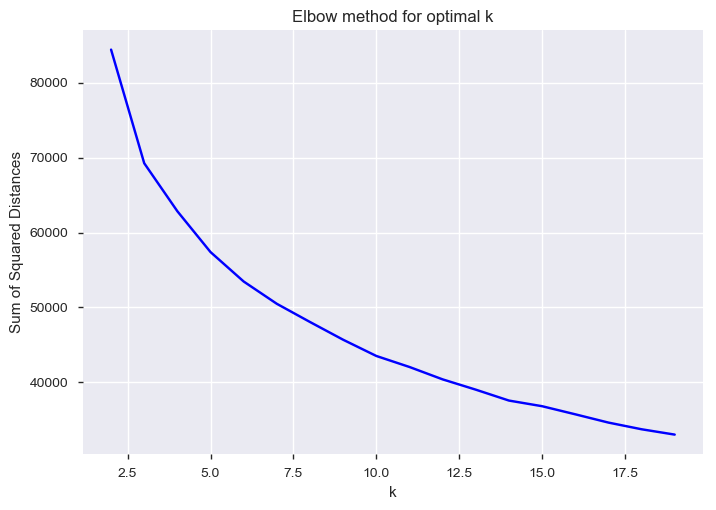

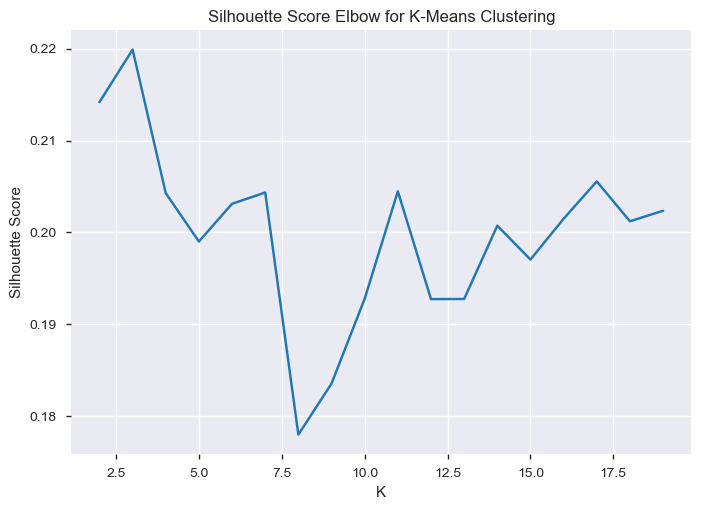

In [0]:
# 2.2  choose K: the number of cluster with an Elbow plot
from sklearn import cluster, datasets, metrics
from sklearn.metrics import silhouette_score
def plot_elbow(df, K, fig_opts=None):
    X = np.array(df)
    sumOfSqrdDist = []
    inertias = []
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42) # the random_state should be 42 instead of 0
        kmeans = kmeans.fit(X)
        sumOfSqrdDist.append(kmeans.inertia_)
    plt.plot(K, sumOfSqrdDist, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum of Squared Distances')
    plt.title('Elbow method for optimal k')
    plt.show()
    
    # silhouette score to see the clustering consistency 
    sumOfSquaredErrors = []
    for k in K:
        kmeans = KMeans(n_clusters=k).fit(X)
        sumOfSquaredErrors.append([k,silhouette_score(X, kmeans.labels_)])
    plt.plot(pd.DataFrame(sumOfSquaredErrors)[0],pd.DataFrame(sumOfSquaredErrors)[1])
    plt.title('Silhouette Score Elbow for K-Means Clustering')
    plt.ylabel('Silhouette Score')
    plt.xlabel('K')
    plt.show()
        

plot_elbow(df_scaled, range(2, 20))

# To measure the clsutering consistency, I used silhouette score ( between -1 and 1, we aim for high value)
#(The silhouette score: the mean silhouette coefficient for all samples/the calinski_harabaz score computes the ratio of dispersion between and within clusters.)

# in this analysis, it seems reasonable to start with k =3, which gave the highest silhouette score.

In [0]:
# 2.3 model building 
kmeans = cluster.KMeans(n_clusters=3, random_state=42)
kmeans.fit(df_scaled)
df_scaled['cluster'] = kmeans.labels_   #save the cluster label as a new column
centroids = kmeans.cluster_centers_   #get the center of the cluster


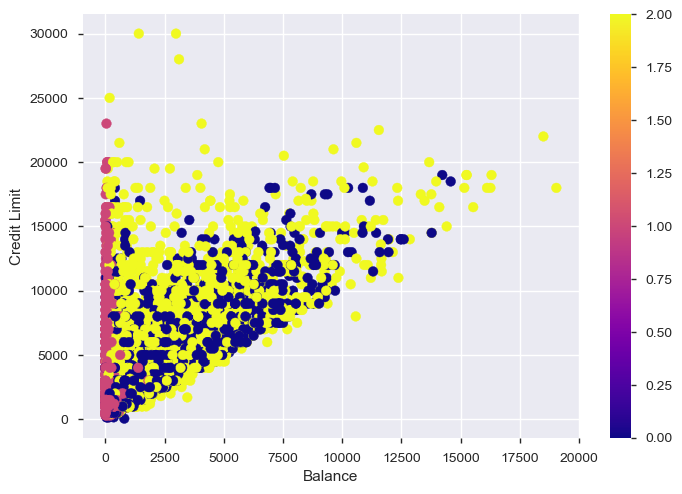

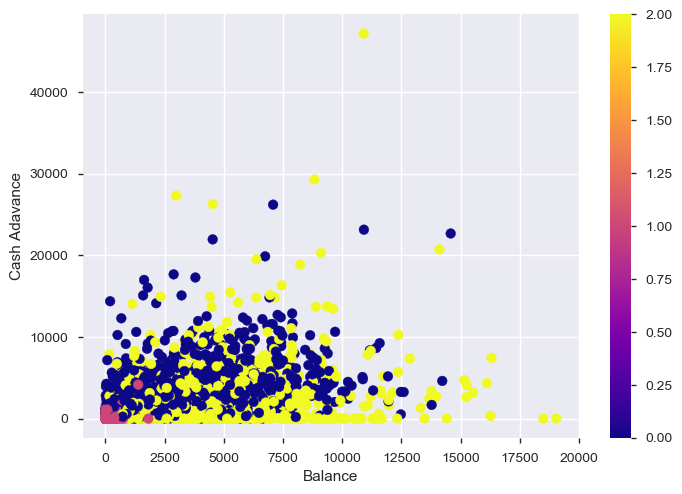

In [0]:
# 2.3.1  2-D plot 
k = KMeans(n_clusters=3, random_state=50)
pred = k.fit_predict(df_scaled)
plt.scatter(x='BALANCE',
       y='CREDIT_LIMIT',data=df2,
      c=pred, cmap='plasma')  # plasma color associate with pred after kmeans.fit.predict 
plt.xlabel('Balance')
plt.ylabel('Credit Limit')
plt.colorbar()
plt.show()

plt.scatter(x='BALANCE',
       y='CASH_ADVANCE',data=df2,
      c=pred, cmap='plasma')
plt.xlabel('Balance')
plt.ylabel('Cash Adavance')
plt.colorbar()
plt.show()
centroids = k.cluster_centers_
# The clusters are not globular, not easy to visualize, move to 2.3.2 



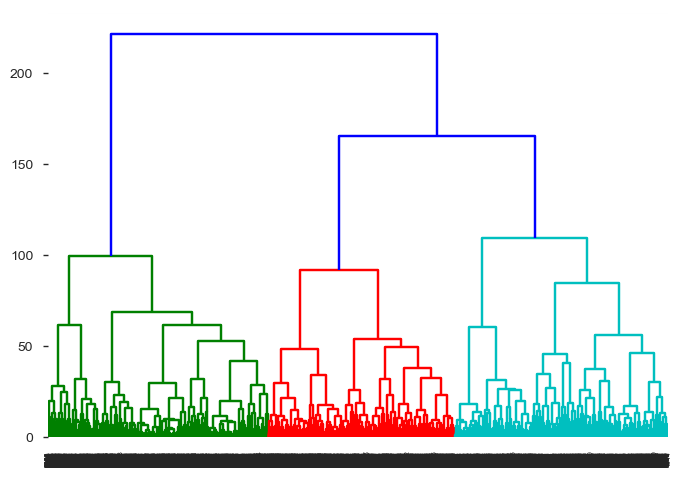

In [0]:
# 2.3.2 density based algorithm 
# create dendrogram 
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(df_scaled, method='ward'))


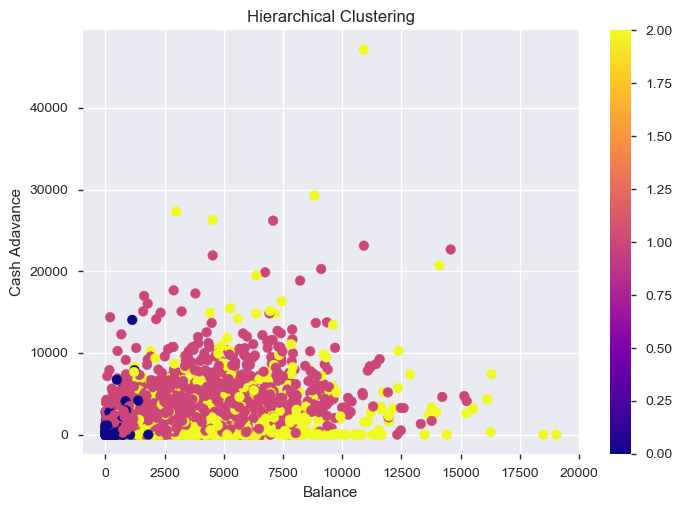

In [0]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters=3, affinity = 'euclidean',linkage = 'ward')
pred_hc = hc.fit_predict(df_scaled)
plt.scatter(x='BALANCE',
       y='CASH_ADVANCE',data=df2, c=pred_hc, cmap='plasma')
plt.colorbar()
plt.xlabel('Balance')
plt.ylabel('Cash Adavance')
plt.title('Hierarchical Clustering')
plt.show()

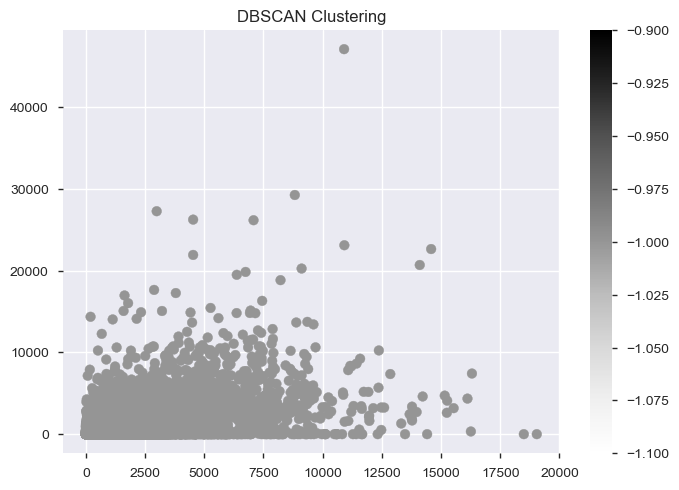

In [0]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps =0.0001, min_samples =10).fit(df_scaled)
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels = dbscan.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
plt.scatter(df2['BALANCE'],df2['CASH_ADVANCE'],
                     c=dbscan.labels_)
plt.title('DBSCAN Clustering')
plt.colorbar()
plt.show()
# I tried different eps (a maximum distance (eps) around a seed), all gave me only one cluster 

## 3. Explore the feature in each cluster 
    3.1 get the users number in each cluster
    
    3.2 get the means of each features in each cluster, using such to quanlitatively/descriptively tell the dominant features in each cluster 

In [0]:
#3.1 users  number in each cluster 
# make a new column to keep the cluster_id 
from copy import deepcopy 
import collections
df_clust = deepcopy(df2) # use the filter-out-correlated-feature data  
df_clust['cluster_id'] = pred_hc 
# get the frequency of any events ( # of users ) in each cluster 
freq = collections.Counter(pred_hc)
print(freq)

Counter({1: 3192, 0: 3066, 2: 2692})


In [0]:
# 3.2 group by cluster_id and then caculate mean values 
#get the means of individual features in each clusters. 
df_clust.groupby(['cluster_id']).mean()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
cluster_id,,,,,,,,,,,,,,,,,
0,175.063618,0.724217,1078.964808,605.342003,474.173516,99.680319,0.638583,0.227518,0.485610,0.023626,0.463144,16.037508,4052.960881,1328.680190,174.220528,0.399873,11.342140
1,2285.699156,0.926250,216.705269,181.054919,35.703192,1936.359091,0.124988,0.084234,0.045242,0.263136,6.227444,2.766917,4274.568049,1632.474968,1076.868463,0.025756,11.280388
2,2291.735865,0.993513,1849.499978,1065.530680,784.277426,844.880528,0.754747,0.314097,0.604911,0.110392,2.889673,27.358841,5257.831285,2313.166387,1371.624113,0.025082,11.997771


Understand the means of individual freatures in each clusters 
-it tells me the dominant features in each clusters, thus,I can make quanlitative/descriptive recommendatioans 

1) although the teneure ranged from 6-12, there is no noticable difference of this feature among three clusters 

2) cluster 0 has low 'balance'; good 'Purchase' 'oneoff_purchase', 'installments_purchase','purcahse_frequency',oneoff_purchases_frequency, Purchases_installments_frequency, 'Purchases_trx' and 'CREDIT_LIMIT'; highest'PRC_FULL_PAYMENT'

3) cluster 1 has pretty high 'Balance', highest' Cash_advance' and 'Cash_adcance_trx'

4) cluster 2 has highest BALANCE, Balance Frequency,ONEOFF_PURCHASES, Intallments_Purchase, Purcahses_Frequency, oneoff_purchases_frequency, Purchases_installments_frequency, Purchases_trx,credit_limit, payments, minimum_payments,

# Conclusion:

## Situaton and Goal of this Analysis:
A senior VP is leading an effort to reduce costs associated with signup incentives by offering credit cards with carefully targeted benefits that will attract new cardholders. As a first step, she would like me to examine cardholder data collected over the last 6 months in order to understand the various kinds of users who use the company’s products. She is especially interested in getting an idea of which benefits to associate with each new card offering.

## Approach:
User segementation with unsupervised learning- kmeans and density-basing clustering. 

## Deliverables: 
The credit card users can be grouped into 3 segments, including frequent credit card users (the cluster 2 in the analysis), users with relatively low uses (the cluster 1) and users possibly building up their credit( the cluster 0). 

The group of frequent credit card users carry features as highest balance, highest purchase frequency, highest credit limit, most frequent payments, highest minimun payment and highest installment Purchase;

The group of users with relatively low uses tend to have high balance, and cash advance. They tend to use credit card to get cash and building up balance. 

The group of users have low 'Balance' and good uses of the credit card like as purcahse frequency, and highest precentage of full payment, likely to be the group of building up their credits. 